In [1]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import os
from glob import glob
import h5py
%matplotlib inline 

In [3]:
base_h5 = os.path.join('..', 'input','mias-mammography', 'all_mias_scans.h5')
tif_dir = 'tiffs'
os.makedirs(tif_dir, exist_ok=True)
with h5py.File(base_h5, 'r') as f:
    mammo_df = pd.DataFrame(
        {k: v.value if len(v.shape)==1 else [sub_v for sub_v in v] 
         for k,v in f.items()})
for k in mammo_df.columns:
    if isinstance(mammo_df[k].values[0], bytes):
        mammo_df[k] = mammo_df[k].map(lambda x: x.decode())
from skimage.io import imsave
def to_path(c_row):
    out_path = os.path.join(tif_dir, '%s.tif' % c_row['REFNUM'])
    imsave(out_path, c_row['scan'])
    return out_path
mammo_df['scan'] = mammo_df.apply(to_path,1)
mammo_df.sample(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys


,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan
207,F,NORM,NaN,mdb205,nan,NaN,NaN,mdb205.pgm,tiffs/mdb205.tif
89,G,NORM,NaN,mdb089,nan,NaN,NaN,mdb089.pgm,tiffs/mdb089.tif
157,F,ARCH,95.0,mdb155,M,448.0,480.0,mdb155.pgm,tiffs/mdb155.tif
86,G,NORM,NaN,mdb086,nan,NaN,NaN,mdb086.pgm,tiffs/mdb086.tif
90,G,ASYM,49.0,mdb090,M,510.0,547.0,mdb090.pgm,tiffs/mdb090.tif


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x71d04d8c9f50>,
      dtype=object)

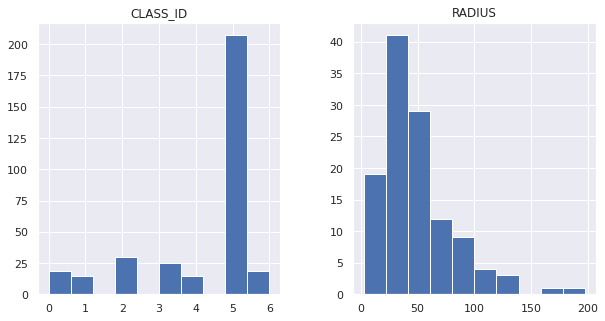

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
class_enc = LabelEncoder()
mammo_df['CLASS_ID'] = class_enc.fit_transform(mammo_df['CLASS'])
mammo_df['CLASS_VEC'] = mammo_df['CLASS_ID'].map(lambda x: to_categorical(x, 
                                                                          num_classes=len(class_enc.classes_)))
mammo_df[['CLASS_ID', 'RADIUS', 'SEVERITY']].hist(figsize = (10, 5))

In [7]:
mammo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BG         330 non-null    object 
 1   CLASS      330 non-null    object 
 2   RADIUS     119 non-null    float64
 3   REFNUM     330 non-null    object 
 4   SEVERITY   330 non-null    object 
 5   X          119 non-null    float64
 6   Y          119 non-null    float64
 7   path       330 non-null    object 
 8   scan       330 non-null    object 
 9   CLASS_ID   330 non-null    int64  
 10  CLASS_VEC  330 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 28.5+ KB


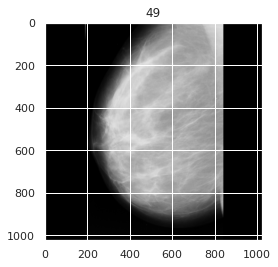

In [8]:
import cv2
import numpy as np
sample_img2 = cv2.imread(mammo_df.scan[49])
color = cv2.cvtColor(sample_img2, cv2.COLOR_BGR2RGB)
plt.imshow(color)
plt.title(mammo_df.index[49])
plt.show()

In [30]:
mammo_df.SEVERITY.value_counts()

nan    207
B       69
M       54
Name: SEVERITY, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(mammo_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = mammo_df[['CLASS_ID', 'SEVERITY']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])
raw_train_df.sample(1)

train 247 validation 83


,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan,CLASS_ID,CLASS_VEC
224,D,CALC,17.0,mdb222,B,398.0,427.0,mdb222.pgm,tiffs/mdb222.tif,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


In [12]:
train_df = raw_train_df.groupby(['CLASS_ID', 'SEVERITY']).apply(lambda x: x.sample(100, replace = True)
                                                      ).reset_index(drop = True)

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
IMG_SIZE = (192, 192) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.2,
                             preprocessing_function = preprocess_input)

In [18]:
no_angles = 360
url ='/kaggle/input/mias-mammography/all-mias/'

In [19]:
def save_dictionary(path,data):
    print('saving catalog...')
    #open('u.item', encoding="utf-8")
    import json
    with open(path,'w') as outfile:
        json.dump(str(data), fp=outfile)
      # save to file:
    print(' catalog saved')

In [20]:
def read_image():
    print("Reading images")
    import cv2
    info = {}
    for i in range(322):
        if i<9:
            image_name='mdb00'+str(i+1)
        elif i<99:
            image_name='mdb0'+str(i+1)
        else:
            image_name = 'mdb' + str(i+1)
        # print(image_name)
        image_address= url+image_name+'.pgm'
        #print(image_address)
        #print(image_address)
        img = cv2.imread(image_address,1)
        # print(i)
        img = cv2.resize(img, (224,224))   #resize image
        rows, cols,color = img.shape
        info[image_name]={}
        for angle in range(0,no_angles,8):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle]=img_rotated
    return (info)

In [21]:
def read_lable():
    print("Reading labels")
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')       
        if len(words)>3:
            if (words[3] == 'B'):
                info[words[0]] = {}
                for angle in range(0,no_angles,8):
                    info[words[0]][angle] = 0
            if (words[3] == 'M'):
                info[words[0]] = {}
                for  angle in range(0,no_angles,8):
                    info[words[0]][angle] = 1
    return (info)

In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
lable_info=read_lable()
image_info=read_image()
#print(image_info[1][0])
ids=lable_info.keys()   #ids = acceptable labeled ids
#print(type(ids))
del lable_info['Truth-Data:']
#print(lable_info)
#print(ids)
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=2021,shuffle=True)
# cancer_prediction_cnn(x_train, y_train, x_test, y_test)

Reading labels
Reading images


In [23]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

(224, 224, 3)
80142336/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
___________________________________________

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

In [26]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=40, batch_size=128,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

save_dictionary('history1.dat', history.history)

Epoch 1/40
30/30 [==============================] - 11s 364ms/step - loss: 0.6695 - accuracy: 0.6792 - val_loss: 3.5839 - val_accuracy: 0.6364
Epoch 2/40
30/30 [==============================] - 9s 312ms/step - loss: 0.1515 - accuracy: 0.9398 - val_loss: 0.9133 - val_accuracy: 0.8409
Epoch 3/40
30/30 [==============================] - 9s 311ms/step - loss: 0.0704 - accuracy: 0.9765 - val_loss: 0.4164 - val_accuracy: 0.9106
Epoch 4/40
30/30 [==============================] - 9s 311ms/step - loss: 0.0456 - accuracy: 0.9834 - val_loss: 0.3039 - val_accuracy: 0.9076
Epoch 5/40
30/30 [==============================] - 9s 310ms/step - loss: 0.0564 - accuracy: 0.9791 - val_loss: 0.1869 - val_accuracy: 0.9394
Epoch 6/40
30/30 [==============================] - 9s 304ms/step - loss: 0.0552 - accuracy: 0.9813 - val_loss: 0.2394 - val_accuracy: 0.9470
Epoch 7/40
30/30 [==============================] - 9s 312ms/step - loss: 0.0374 - accuracy: 0.9853 - val_loss: 0.1045 - val_accuracy: 0.9712
Epoch

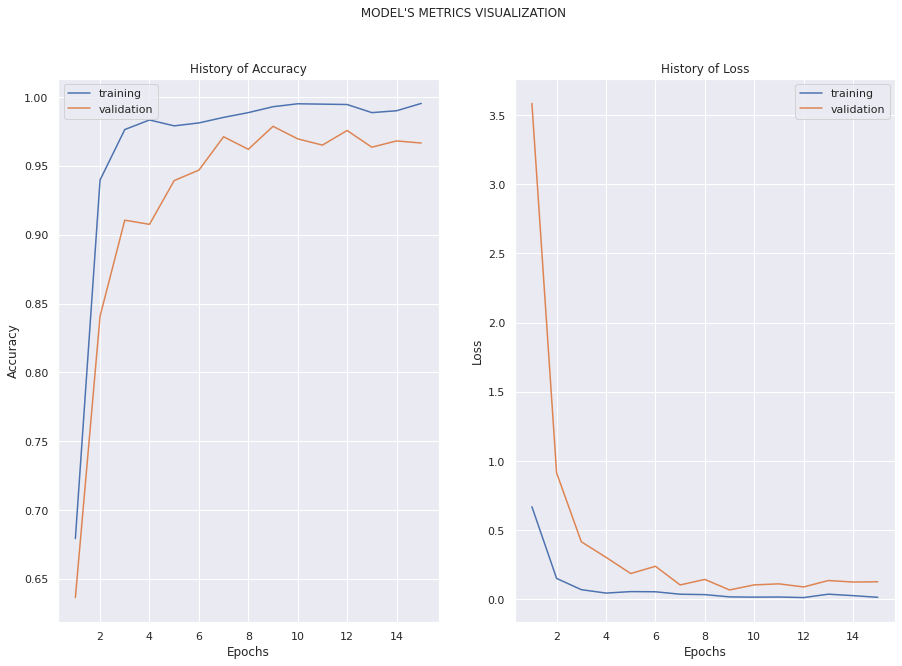

In [27]:

import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [28]:
y_pred=model.predict_classes(x_test)
y_pred_prb=model.predict_proba(x_test)

In [29]:

target=["B","M"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Accuracy: 0.9665
Precision: 0.9671
Recall: 0.9665
F1 Score: 0.9666
ROC AUC Score: 0.9936
Cohen Kappa Score: 0.9328
		Classification Report:
               precision    recall  f1-score   support

           B       0.98      0.95      0.97       418
           M       0.95      0.98      0.96       359

    accuracy                           0.97       777
   macro avg       0.97      0.97      0.97       777
weighted avg       0.97      0.97      0.97       777

